单层全连接SNN网络训练MNIST数据集

In [86]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import numpy as np
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer
import matplotlib.pyplot as plt

SNN网络结构

In [87]:
class SNN(nn.Module):
    def __init__(self, tau):
        super().__init__()

        self.layer = nn.Sequential(
            layer.Flatten(),
            layer.Linear(28 * 28, 10, bias=False),
            neuron.LIFNode(tau=tau, surrogate_function=surrogate.ATan()),
        )

    def forward(self, x: torch.Tensor):
        return self.layer(x)

MNIST数据集数据准备

In [89]:
data_dir = './data'
batch_size = 128
num_workers = 1
train_dataset = torchvision.datasets.MNIST(
        root=data_dir,
        train=True,
        transform=torchvision.transforms.ToTensor(),
        download=True
    )

test_dataset = torchvision.datasets.MNIST(
    root=data_dir,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

train_data_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=True
)
test_data_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=True
)

参数设置，网络优化器

In [90]:
tau = 2.0
T = 100
epochs = 100
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = SNN(tau=tau)
net.to(device)

#使用adam优化器
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#使用泊松编码器
encoder = encoding.PoissonEncoder()

开始训练

In [91]:
train_acc_record = []
train_loss_record = []
test_acc_record = []
test_loss_record = []
for epoch in range(epochs):
    start_time = time.time()
    #训练
    net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    for img, label in train_data_loader:
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        label_onehot = F.one_hot(label, 10).float()

        out_fr = 0.
        for t in range(T):
            encoded_img = encoder(img)
            out_fr += net(encoded_img)
        out_fr = out_fr / T
        loss = F.mse_loss(out_fr, label_onehot)
        loss.backward()
        optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        train_acc += (out_fr.argmax(1) == label).float().sum().item()  
        functional.reset_net(net)

    train_time = time.time()
    train_speed = train_samples / (train_time - start_time)
    train_loss /= train_samples
    train_acc /= train_samples
    train_acc_record.append(train_acc)
    train_loss_record.append(train_loss)

    #测试
    net.eval()
    test_loss = 0
    test_acc = 0
    test_samples = 0
    with torch.no_grad():
        for img, label in test_data_loader:
            img = img.to(device)
            label = label.to(device)
            label_onehot = F.one_hot(label, 10).float()
            out_fr = 0.
            for t in range(T):
                encoded_img = encoder(img)
                out_fr += net(encoded_img)
            out_fr = out_fr / T
            loss = F.mse_loss(out_fr, label_onehot)

            test_samples += label.numel()
            test_loss += loss.item() * label.numel()
            test_acc += (out_fr.argmax(1) == label).float().sum().item()
            
            functional.reset_net(net)
    test_time = time.time()
    test_speed = test_samples / (test_time - train_time)
    test_loss /= test_samples
    test_acc /= test_samples
    test_acc_record.append(test_acc)
    test_loss_record.append(test_loss)

    print(f'epoch ={epoch}, train_loss ={train_loss: .4f}, train_acc ={train_acc: .4f}, test_loss ={test_loss: .4f}, test_acc ={test_acc: .4f}')
    print(f'train speed ={train_speed: .4f} images/s, test speed ={test_speed: .4f} images/s')
    print('escape time: ' , time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))) 

epoch =0, train_loss = 0.0321, train_acc = 0.8482, test_loss = 0.0213, test_acc = 0.9068
train speed = 1532.7988 images/s, test speed = 1595.2073 images/s
escape time:  2024-06-20 18:15:03
epoch =1, train_loss = 0.0203, train_acc = 0.9057, test_loss = 0.0187, test_acc = 0.9155
train speed = 1628.4058 images/s, test speed = 1554.9597 images/s
escape time:  2024-06-20 18:15:46
epoch =2, train_loss = 0.0186, train_acc = 0.9116, test_loss = 0.0176, test_acc = 0.9158
train speed = 1413.9037 images/s, test speed = 1507.3207 images/s
escape time:  2024-06-20 18:16:35
epoch =3, train_loss = 0.0176, train_acc = 0.9152, test_loss = 0.0169, test_acc = 0.9184
train speed = 1387.9485 images/s, test speed = 1515.1414 images/s
escape time:  2024-06-20 18:17:25
epoch =4, train_loss = 0.0171, train_acc = 0.9177, test_loss = 0.0165, test_acc = 0.9204
train speed = 1549.7207 images/s, test speed = 1598.4257 images/s
escape time:  2024-06-20 18:18:10
epoch =5, train_loss = 0.0167, train_acc = 0.9187, test

In [5]:
print(f'epoch ={epoch}, train_loss ={train_loss: .4f}, train_acc ={train_acc: .4f}, test_loss ={test_loss: .4f}, test_acc ={test_acc: .4f}')
print(f'train speed ={train_speed: .4f} images/s, test speed ={test_speed: .4f} images/s')

print('escape time: ' , time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))) 

NameError: name 'epoch' is not defined

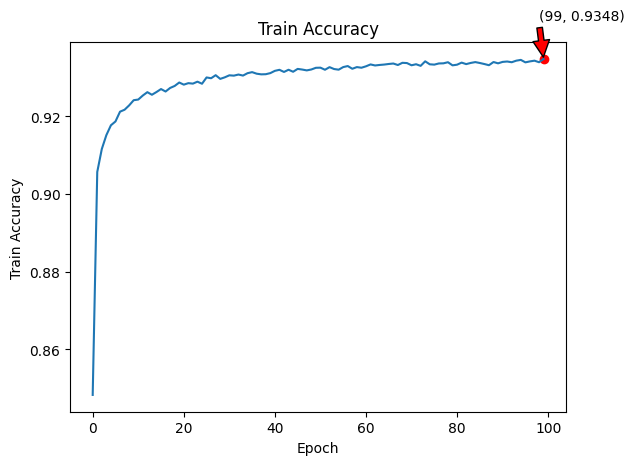

In [118]:
# 训练集正确率变化图像
plt.plot(train_acc_record)
idx = np.argmax(train_acc_record)
plt.scatter(idx, train_acc_record[idx], c='r')
plt.annotate(f'({idx}, {train_acc_record[idx]:.4f})', (idx, train_acc_record[idx]), 
             xytext=(idx-1, train_acc_record[idx]+0.01), 
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracy')
plt.show()

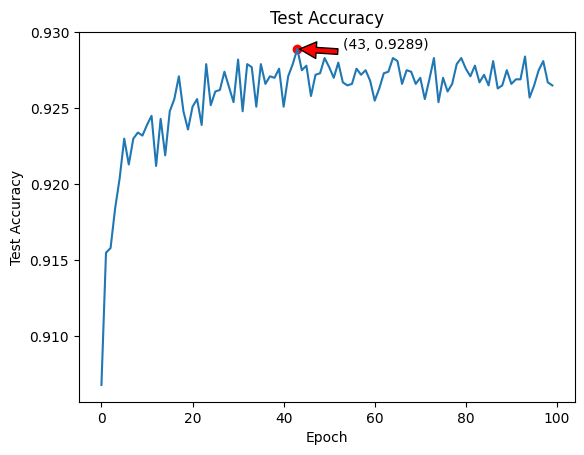

In [121]:
# 测试集正确率变化图像
plt.plot(test_acc_record)
idx = np.argmax(test_acc_record)
plt.scatter(idx, test_acc_record[idx], c='r')
plt.annotate(f'({idx}, {test_acc_record[idx]:.4f})', (idx, test_acc_record[idx]), 
             xytext=(idx+10, test_acc_record[idx]), 
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy')
plt.show()

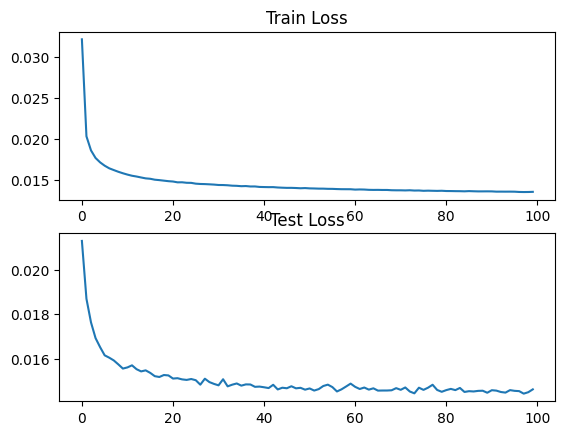

In [124]:
#训练集损失变化图像
fig = plt.figure()
ax = fig.add_subplot(2,1, 1)
ax.plot(train_loss_record)
ax.xaxis.axis_name = 'Epoch'
ax.yaxis.axis_name = 'Train Loss'
ax.set_title(f'Train Loss')
ax = fig.add_subplot(2,1, 2)
ax.plot(test_loss_record)
ax.xaxis.axis_name = 'Epoch'
ax.yaxis.axis_name = 'Test Loss'
ax.set_title(f'Test Loss')
plt.show()

In [133]:
#保存模型
checkpoint = {
    'net': net.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(checkpoint, 'snn_mnist.pth')

In [135]:
# 图片enumerate
test_data_loader_example = data.DataLoader(
    dataset=test_dataset,
    shuffle=True,
    batch_size=64
)

examples = enumerate(test_data_loader_example)

batch_idx, (imgs, labels) = next(examples)



C:\Users\CodeAlan\AppData\Local\Temp\ipykernel_26272\1246623428.py:15: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out_fr, label_onehot)


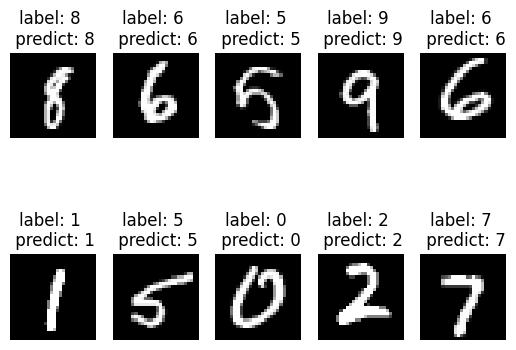

In [136]:


fig = plt.figure()
#抽取10张图片测试
net.eval()
for i in range(10):
    with torch.no_grad():
        
        img = imgs[i].to(device)
        label = labels[i].to(device)
        label_onehot = F.one_hot(label, 10).float()
        out_fr = 0.
        for t in range(T):
            encoded_img = encoder(img)
            out_fr += net(encoded_img)
        out_fr = out_fr / T
        loss = F.mse_loss(out_fr, label_onehot)

        test_samples += label.numel()
        test_loss += loss.item() * label.numel()
        test_acc += (out_fr.argmax(1) == label).float().sum().item()
        functional.reset_net(net)

        # print(f'predict: {out_fr.argmax(1)}')
        # print(f'label: {label}')


        img = imgs[i].squeeze()
        ax = fig.add_subplot(2, 5, i + 1)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'label: {label} \n predict: {out_fr.argmax(1).item()}')
        ax.axis('off')